### Import packages

In [23]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import xarray as xr
from skimage import io
import subprocess
from osgeo import gdal, osr

import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import cartopy.feature as cf
from cartopy.util import add_cyclic_point

import rioxarray as rxr
import rasterio

import georaster
from mpl_toolkits.basemap import Basemap
import matplotlib.colors

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

## Datasets:

### Altimetry from Climate Central

### Tidal and storm surge contributions from 'Water level change indicators for the European coast from 1977 to 2100 derived from climate projections'
https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators?tab=overview

Historical values from ERA5 reanalysis: from 1979 to 2005 

Separate the surge and tidal contributions to the extremes

### Sea level rise from IPCC 
Visualization of sea level rise here: https://sealevel.nasa.gov/data_tools/17

## Load altimetry data

In [24]:
fp_dem =  "/Users/annalea_albright/Dropbox/BPCE/Data/output.tif"

In [25]:
dem = rxr.open_rasterio(fp_dem).squeeze()
# mask where values equal to 1 = bodies of water
dem = dem.where(dem != 1)  

print(dem)
print("The CRS for this data is:", dem.rio.crs) # dem.rio.crs.to_epsg()
print("The spatial extent is:", dem.rio.bounds())
print("The no data value is:", dem.rio.nodata)

if 0:
    dem.plot(
            cmap="terrain", 
             vmin=0, 
             vmax=300
            )


<xarray.DataArray (y: 12010, x: 16814)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 1
  * x            (x) float64 -6.0 -5.999 -5.998 -5.997 ... 7.997 7.998 7.999 8.0
  * y            (y) float64 52.0 52.0 52.0 52.0 52.0 ... 42.0 42.0 42.0 42.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_SOFTWARE:          MATLAB 9.10, Mapping Toolbox 5.1
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        2810
    STATISTICS_MEAN:           55.012221700469
    STATISTICS_MINIMUM:        -16
    STATISTICS_STDDEV:         161.51773209059
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
The CRS for this data is: EPSG:4326
The spat

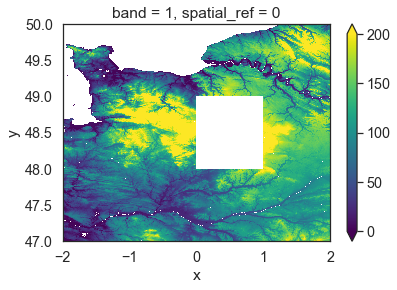

In [53]:
# plot a subset as test
test = dem.sel(x=slice(-2, 2)).sel(y=slice(50,47))
#print(test.values)
test.plot(
        vmin=0,
         vmax=200,
#    robust=True, # 2-98% percentile, but specify manually because of the Alps
)

In [20]:
print('longititude values of altimetry data go from', dem.x.min().values,
      dem.x.max().values,
     )

longititude values of altimetry data go from -5.999583680266444 7.999583680266444


## To do's

* load dataframes saved from previously

* For each region, find aoi_lat and aoi_lon

* select corresponding storm surge value and tide range

* add it to that part of the DEM 

* but the issue is that DEM has vertical datum of EGM96 and storm surge and tidal data are referenced to mean sea level

* loop over regions

* look where < 0

* export as geoTIFF


## Load data for each region calculated previously, in file 
`Calculate_tide_surge_per_region.ipynb`

In [26]:
folder_save = '/Users/annalea_albright/Dropbox/BPCE/Data/'

df_2_surge = pd.read_csv(os.path.join(folder_save, 'df_pd_2year_surge.csv'))
df_5_surge = pd.read_csv(os.path.join(folder_save, 'df_pd_5year_surge.csv'))
df_100_surge = pd.read_csv(os.path.join(folder_save, 'df_pd_100year_surge.csv'))
df_pd_tides = pd.read_csv(os.path.join(folder_save, 'df_pd_tides.csv'))

df_2_surge

,Unnamed: 0,Region,lat_min,lat_max,lon_min,lon_max,var_mean
0,0,Nord-Pas-de-Calais,49.970657,51.089397,361.555278,364.230134,1.700845
1,1,Picardie,48.838474,50.368549,361.379723,364.255734,2.091533
2,2,Haute-Normandie,48.666523,50.071552,360.065138,361.802660,1.551201
3,3,Basse-Normandie,48.180092,49.728195,357.935972,360.976416,1.376926
4,4,Bretagne,47.278751,49.105694,354.856249,358.981797,0.936830
5,5,Pays de la Loire,46.266804,48.568001,357.373472,360.916650,0.918620
6,6,Poitou-Charentes,45.089249,47.175758,358.436805,361.213066,0.867562
7,7,Aquitaine,42.777672,45.714569,358.211528,361.448261,0.585984
8,8,Languedoc-Roussillon,42.333443,44.975723,361.688420,364.845344,0.388612
9,9,Provence-Alpes-Côte d'Azur,42.981529,45.126846,364.229758,367.716127,0.356542


In [27]:
df_pd_tides

,Unnamed: 0,Region,lat_min,lat_max,lon_min,lon_max,var_mean
0,0,Nord-Pas-de-Calais,49.970657,51.089397,361.555278,364.230134,4.376885
1,1,Picardie,48.838474,50.368549,361.379723,364.255734,5.880680
2,2,Haute-Normandie,48.666523,50.071552,360.065138,361.802660,4.764923
3,3,Basse-Normandie,48.180092,49.728195,357.935972,360.976416,4.766192
4,4,Bretagne,47.278751,49.105694,354.856249,358.981797,4.239764
5,5,Pays de la Loire,46.266804,48.568001,357.373472,360.916650,2.827109
6,6,Poitou-Charentes,45.089249,47.175758,358.436805,361.213066,2.921874
7,7,Aquitaine,42.777672,45.714569,358.211528,361.448261,2.539386
8,8,Languedoc-Roussillon,42.333443,44.975723,361.688420,364.845344,0.163846
9,9,Provence-Alpes-Côte d'Azur,42.981529,45.126846,364.229758,367.716127,0.171876


## Define a function that selects the area of interest (AOI), finds corresponding storm surge and tidal value, chooses a sea level rise value, and then subtracts it from the digital elevation model (altimetry data from Climate Central)

## Just tides

In [29]:
def subtract_value_from_region_DEM_just_tides(
    dem,
    df, # for the surge or tide value
    region_sel,
):
    
    # indexing location based on the tidal and storm surge data
    aoi_lat = [df.loc[df["Region"] == region_sel, "lat_min"].values[0],
               df.loc[df["Region"] == region_sel, "lat_max"].values[0]
              ]
    aoi_lon = [df.loc[df["Region"] == region_sel, "lon_min"].values[0],
               df.loc[df["Region"] == region_sel, "lon_max"].values[0]
              ]
#     print(aoi_lat)
#     print(aoi_lon)  
    
    # tide
    tide_sel = df_pd_tides.loc[df_pd_tides["Region"] == region_sel, "var_mean"].values[0]
    
    # Define the range of coordinates for modification
    x_range = slice(aoi_lon[0]-360, aoi_lon[1]-360) # factor 360 is to convert to -10, 10 format, W and E of 0
    y_range = slice(aoi_lat[1], aoi_lat[0]) # this requires going from upper-->lower

    # Add a number to the selected range of coordinates
    dem.loc[dict(x=x_range, y=y_range)] -= tide_sel  
    
    return dem

In [30]:
# re-open file each time because the function call modifies the file
dem = rxr.open_rasterio(fp_dem).squeeze()
# mask where values equal to 1 = bodies of water
dem = dem.where(dem != 1)  

print(np.mean(dem).values) # means to check that it is subtracting progressively from each region

for region in zones_coast:
    print(region)
    dem = subtract_value_from_region_DEM_just_tides(
                                        dem,
                                        df_2_surge,
                                        region_sel=region,
                                        )    
    print(np.mean(dem).values)
print('new total mean', np.mean(dem).values)

dem_tides = dem

167.05403080941096
Nord-Pas-de-Calais
166.77931610802764
Picardie
166.25812011611512
Haute-Normandie
166.0683554721717
Basse-Normandie
165.76367556509825
Bretagne
165.36484579554585
Pays de la Loire
164.9821165630525
Poitou-Charentes
164.7369216679529
Aquitaine
164.443233671067
Languedoc-Roussillon
164.43017374085943
Provence-Alpes-Côte d'Azur
164.41910483237558
new total mean 164.41910483237558


## All components : tidal level, storm surge, sea level rise

In [31]:
def subtract_value_from_region_DEM(
    dem,
    df, # for the surge value
    region_sel,
    sea_level_rise=0.6,
):
    
    aoi_lat = [df.loc[df["Region"] == region_sel, "lat_min"].values[0],
               df.loc[df["Region"] == region_sel, "lat_max"].values[0]
              ]
    aoi_lon = [df.loc[df["Region"] == region_sel, "lon_min"].values[0],
               df.loc[df["Region"] == region_sel, "lon_max"].values[0]
              ]
#     print(aoi_lat)
#     print(aoi_lon)  
    
    # storm surge
    surge_sel = df.loc[df["Region"] == region_sel, "var_mean"].values[0]
    # tide
    tide_sel = df_pd_tides.loc[df_pd_tides["Region"] == region_sel, "var_mean"].values[0]
    
    # Define the range of coordinates for modification
    x_range = slice(aoi_lon[0]-360, aoi_lon[1]-360) # factor 360 is to convert to -10, 10 format, W and E of 0
    y_range = slice(aoi_lat[1], aoi_lat[0]) # this requires going from upper-->lower

    # Add a number to the selected range of coordinates
    #sea_level_rise = 0.2 # 0.4, 0.6
    dem.loc[dict(x=x_range, y=y_range)] -= (surge_sel + tide_sel + sea_level_rise)  # 0.6 for sea level rise in 2100
    
    return dem

## call this function

## also specify sea level rise level `sea_level_rise` parameter

* under SSP3-7.0 scenario (medium-high, business as usual)
*  `sea_level_rise` = 0.2 for 2050
*  `sea_level_rise` = 0.4 for 2075
*  `sea_level_rise` = 0.6 for 2100 

## 2 year return period, with 0.2 m of sea level rise (lower end member)

In [33]:
# re-open file each time because the function call modifies the file
dem = rxr.open_rasterio(fp_dem).squeeze()
# mask where values equal to 1 = bodies of water
dem = dem.where(dem != 1)  

print(np.mean(dem).values) # means to check that it is subtracting progressively from each region

for region in zones_coast:
    print(region)
    dem = subtract_value_from_region_DEM(
                                        dem,
                                        df_2_surge,
                                        region_sel=region,
                                        sea_level_rise = 0.2, # 0.4, 0.6
                                        )    
    print(np.mean(dem).values)
print('new total mean', np.mean(dem).values)

dem_2 = dem

167.05403080941096
Nord-Pas-de-Calais
166.66000978471473
Picardie
165.93571861476252
Haute-Normandie
165.6762118248729
Basse-Normandie
165.2707265526929
Bretagne
164.76495648403846
Pays de la Loire
164.2307903284516
Poitou-Charentes
163.8960088500053
Aquitaine
163.51141937701493
Languedoc-Roussillon
163.45144195065694
Provence-Alpes-Côte d'Azur
163.40453151969305
new total mean 163.40453151969305


## 100 year return period, with 0.6 m of sea level rise (upper end member)

In [34]:
dem = rxr.open_rasterio(fp_dem).squeeze()
# mask where values equal to 1 = bodies of water
dem = dem.where(dem != 1)  

print(np.mean(dem).values) # means to check that it is subtracting progressively from each region

for region in zones_coast:
    print(region)
    dem = subtract_value_from_region_DEM(
                                        dem,
                                        df_100_surge,
                                        region_sel=region,
                                        sea_level_rise = 0.6, 
                                        )    
    print(np.mean(dem).values)
print('new total mean', np.mean(dem).values)

dem_100 = dem

167.05403080941096
Nord-Pas-de-Calais
166.55776056314875
Picardie
165.65746038457848
Haute-Normandie
165.33438055912873
Basse-Normandie
164.8414896428763
Bretagne
164.24310549301984
Pays de la Loire
163.5687311674978
Poitou-Charentes
163.15035895469856
Aquitaine
162.67638596218953
Languedoc-Roussillon
162.56410998259105
Provence-Alpes-Côte d'Azur
162.47603010684008
new total mean 162.47603010684008


## How different is it between 2 and 100 year return periods, and just the tides?

In [37]:
def make_plot_differences_zones(
                        xrange,
                         yrange
):
    plt.figure(figsize=(20,10))
    dem_sel_100 = dem_100.sel(x=xrange).sel(y=yrange)
    (dem_sel_100<0).plot(
        vmin=0,
               vmax=1,
              #vmin=-10,
              #vmax=0
              cmap=matplotlib.colors.ListedColormap(['white', 'navy']), # crimson,
    )


    dem_sel_2 = dem_2.sel(x=xrange).sel(y=yrange)
    (dem_sel_2<0).plot(
        vmin=0,
               vmax=1,
              #vmin=-10,
              #vmax=0,
              cmap=matplotlib.colors.ListedColormap(['white', 'firebrick']), # crimson,
        alpha=0.5,

    )

    dem_sel_justtide = dem_tides.sel(x=xrange).sel(y=yrange)
    (dem_sel_justtide<0).plot(
        vmin=0,
               vmax=1,
              #vmin=-10,
              #vmax=0,
              cmap=matplotlib.colors.ListedColormap(['white', 'yellow']), # crimson,
        alpha=0.5,

    )

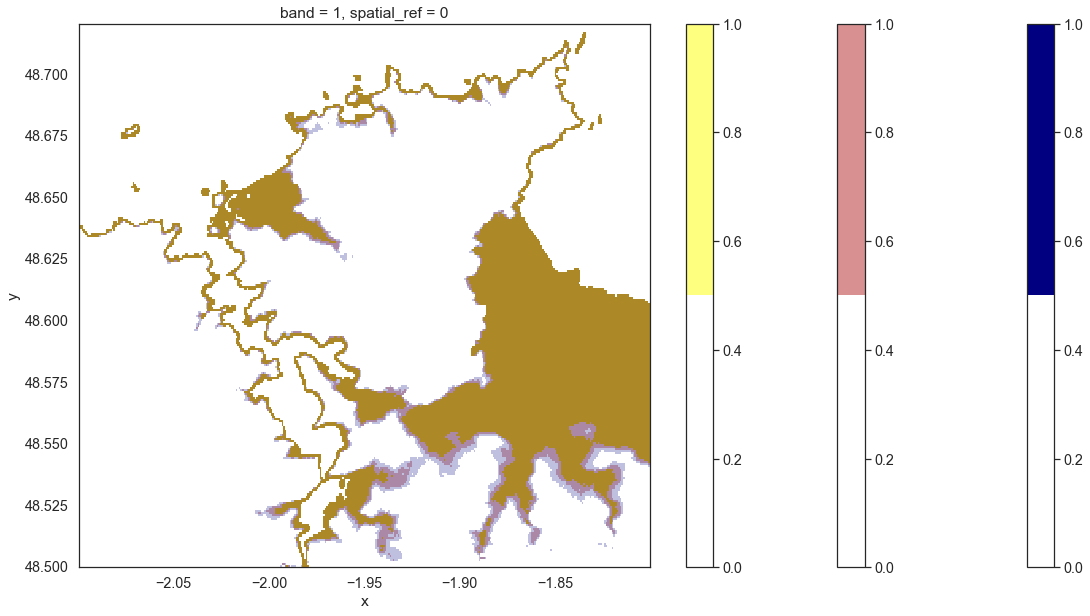

In [38]:
xrange = slice(-2.1, -1.8)
yrange = slice(48.72, 48.5)

make_plot_differences_zones(
                        xrange,
                         yrange
)

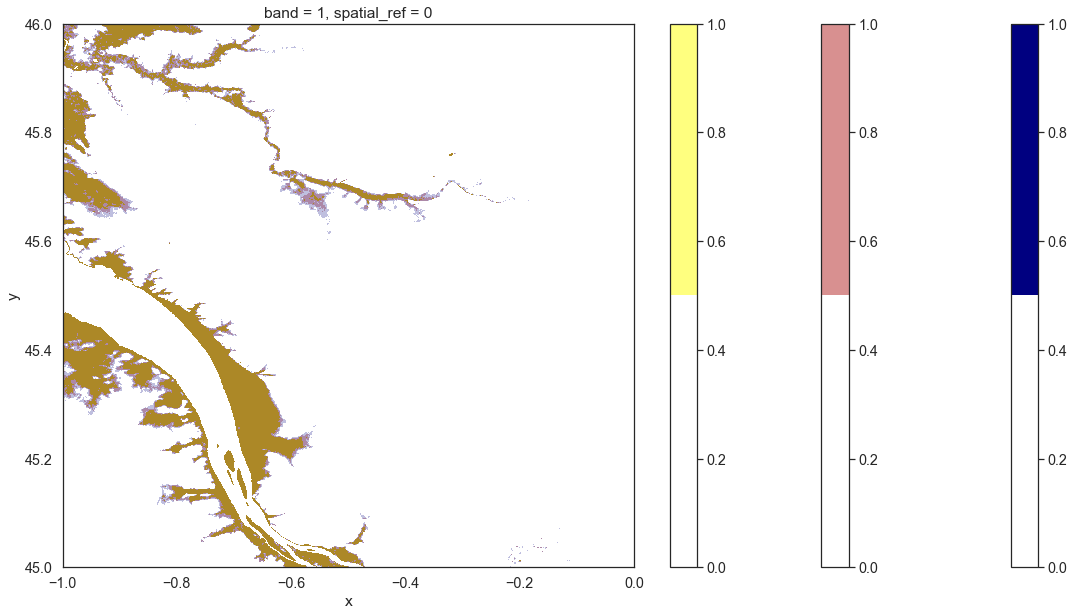

In [39]:
xrange = slice(-1, 0)
yrange = slice(46,45)

make_plot_differences_zones(
                        xrange,
                         yrange
)

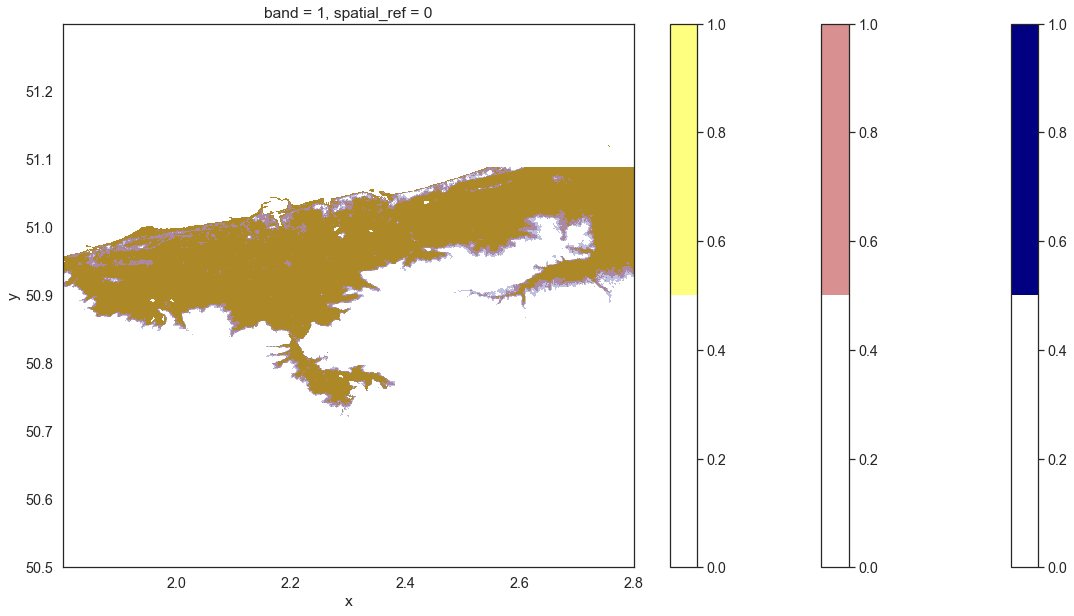

In [40]:
xrange = slice(1.8, 2.8)
yrange = slice(51.3, 50.5)

make_plot_differences_zones(
                        xrange,
                         yrange
)

## Saving new geoTIFF files

In [41]:
def save_geotiff_file(
    array_to_save,
    fp_save,
):
    
    # Path to the array data file
    #array_file = 'path/to/array_data.npy'

    # Path to the reference GeoTIFF file for metadata
    reference_file = "/Users/annalea_albright/Dropbox/BPCE/Data/output.tif"

    # Load the array data from the file
    array_data = array_to_save 

    # Open the reference GeoTIFF file to retrieve the metadata
    with rasterio.open(reference_file) as ref_src:
        # Create a new profile using the metadata from the reference file
        profile = ref_src.profile

        # Update the profile with the array data dimensions
        profile.update(
            width=array_data.shape[1],
            height=array_data.shape[0]
        )

    # Save the array as a new GeoTIFF file
    output_file = fp_save
    with rasterio.open(output_file, 'w', **profile) as out_src:
        out_src.write(array_data, 1)

In [42]:
save_geotiff_file(
    array_to_save=dem_tides,
    fp_save='/Users/annalea_albright/Dropbox/BPCE/Data/dem_tides.tif',
)

In [43]:
save_geotiff_file(
    array_to_save=dem_2,
    fp_save='/Users/annalea_albright/Dropbox/BPCE/Data/output_dem_2.tif',
)

In [44]:
save_geotiff_file(
    array_to_save=dem_100,
    fp_save='/Users/annalea_albright/Dropbox/BPCE/Data/output_dem_2.tif',
)

### save as netCDF (old)

In [22]:
test_less_than = (dem<0).astype('uint8')
test_less_than
fp_save_netCDF = '/Users/annalea_albright/Dropbox/BPCE/Data/save_netCDF_below_zero.nc'
test_less_than.to_netcdf(fp_save_netCDF)